In [45]:
import sklearn
import sklearn.preprocessing
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import GaussianNoise

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

%matplotlib inline
from pandas.plotting import scatter_matrix

### Dataset Cleaning and reformat

In [79]:
data = pd.read_csv('data/PRSA_data_2010.1.1-2014.12.31.csv')
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [80]:
data["timestamp"] = pd.to_datetime(data[["year", "month", "day", "hour"]])

In [81]:
data = data.set_index("timestamp")

In [82]:
data.drop(["No", "year", "month", "day", "hour"], axis=1, inplace=True)

In [83]:
data.head(20)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [84]:
# Shape
print(data.shape)

(43824, 8)


In [85]:
# Drop rows with NAN value 
data = data.dropna()
data.head(20)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [86]:
# Shape
print(data.shape)

(41757, 8)


In [87]:
# Factorize String data
data.loc[:, 'cbwd'] = pd.factorize(data.loc[:, 'cbwd'])[0]
data.head(20)

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,0,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,0,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,0,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,0,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,0,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,0,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,0,12.51,0,0


In [88]:
# Saved cleaned data
data.to_csv('data/cleaned_data')

### Data Static Summary

In [89]:
print(data.describe())

              pm2.5          DEWP          TEMP          PRES          cbwd  \
count  41757.000000  41757.000000  41757.000000  41757.000000  41757.000000   
mean      98.613215      1.750174     12.401561   1016.442896      1.201715   
std       92.050387     14.433658     12.175215     10.300733      1.042515   
min        0.000000    -40.000000    -19.000000    991.000000      0.000000   
25%       29.000000    -10.000000      2.000000   1008.000000      0.000000   
50%       72.000000      2.000000     14.000000   1016.000000      1.000000   
75%      137.000000     15.000000     23.000000   1025.000000      2.000000   
max      994.000000     28.000000     42.000000   1046.000000      3.000000   

                Iws            Is            Ir  
count  41757.000000  41757.000000  41757.000000  
mean      23.866747      0.055344      0.194866  
std       49.617495      0.778875      1.418165  
min        0.450000      0.000000      0.000000  
25%        1.790000      0.000000     

### Dataset Visualization

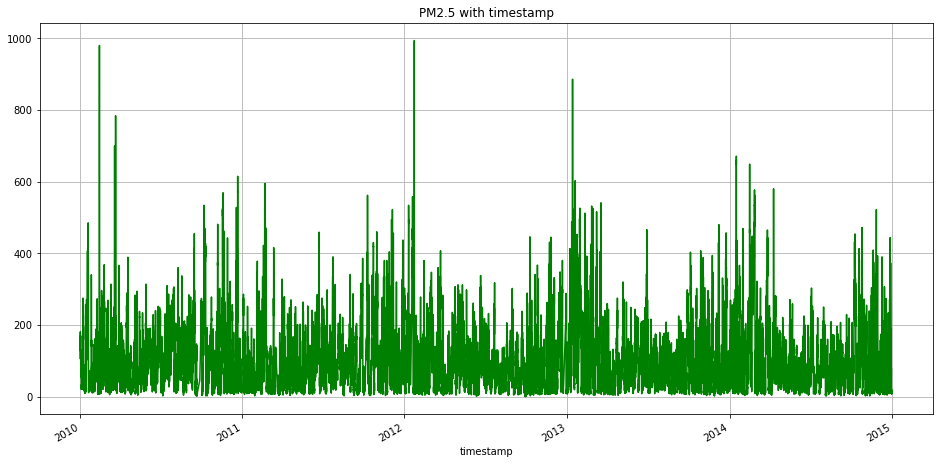

In [90]:
# Show how data looks like
plt.figure(figsize=[16, 8])
data['pm2.5'].plot(kind='line',color='green',grid=True)
plt.title("PM2.5 with timestamp");

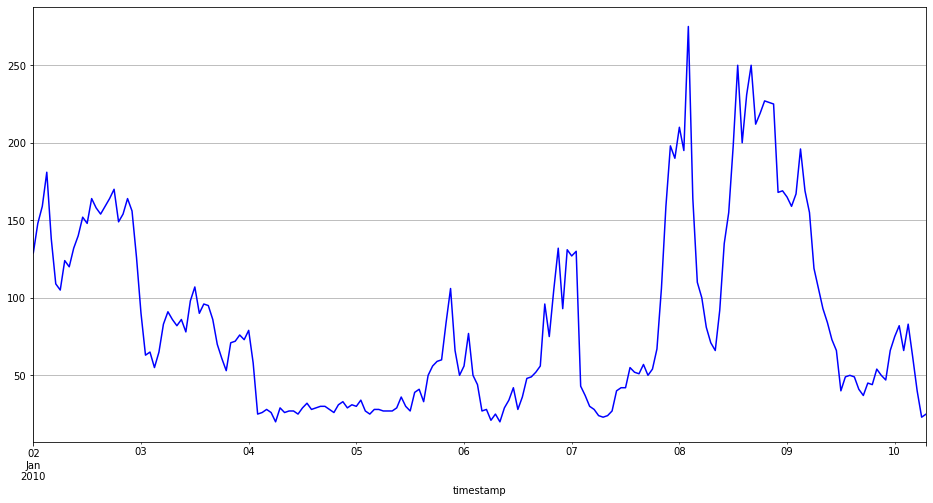

In [91]:
# Show one month zoom in pm2.5 data
plt.figure(figsize=[16, 8])
data['pm2.5'][:200].plot(kind='line',color='blue',grid=True);

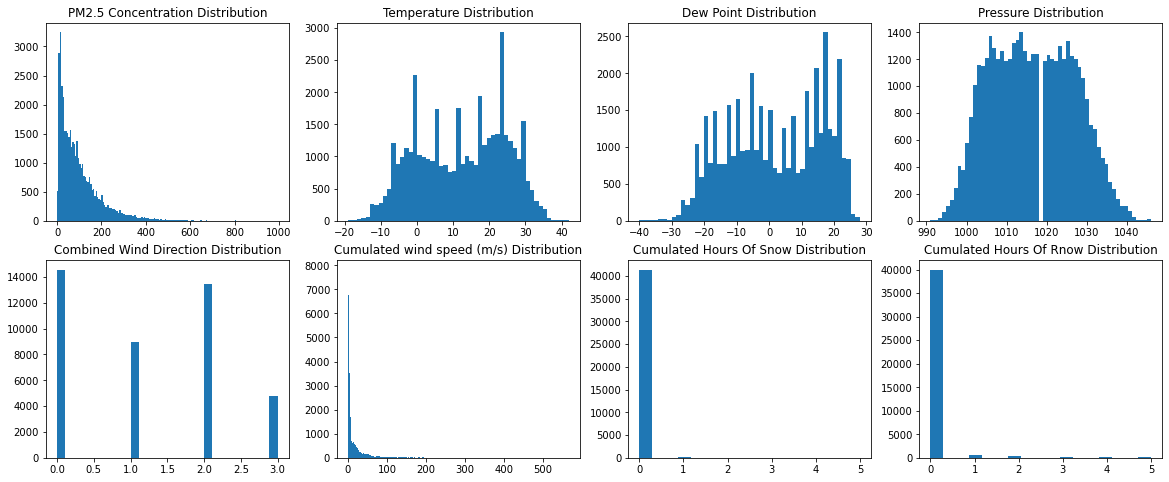

In [92]:
# Show data distribution
plt.figure(figsize=[20,8])
plt.subplot(2, 4, 1)
plt.hist(data['pm2.5'], bins='auto')
plt.title('PM2.5 Concentration Distribution')
plt.subplot(2, 4, 2)
plt.hist(data['TEMP'], bins='auto')
plt.title('Temperature Distribution')
plt.subplot(2, 4, 3)
plt.hist(data['DEWP'], bins='auto')
plt.title('Dew Point Distribution')
plt.subplot(2, 4, 4)
plt.hist(data['PRES'], bins='auto')
plt.title('Pressure Distribution')
plt.subplot(2, 4, 5)
plt.hist(data['cbwd'], bins='auto')
plt.title('Combined Wind Direction Distribution')
plt.subplot(2, 4, 6)
plt.hist(data['Iws'], bins='auto')
plt.title('Cumulated wind speed (m/s) Distribution')
plt.subplot(2, 4, 7)
plt.hist(data['Is'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Snow Distribution')
plt.subplot(2, 4, 8)
plt.hist(data['Ir'], bins='auto', range=[0,5])
plt.title('Cumulated Hours Of Rnow Distribution');

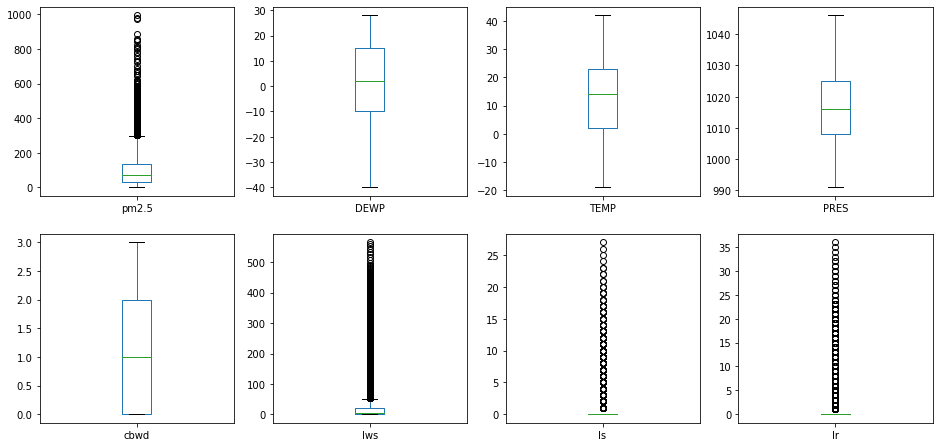

In [93]:
# Univariate plot
data.plot(kind='box', subplots=True, layout=(4,4), figsize=[16,16], sharex=False, sharey=False);

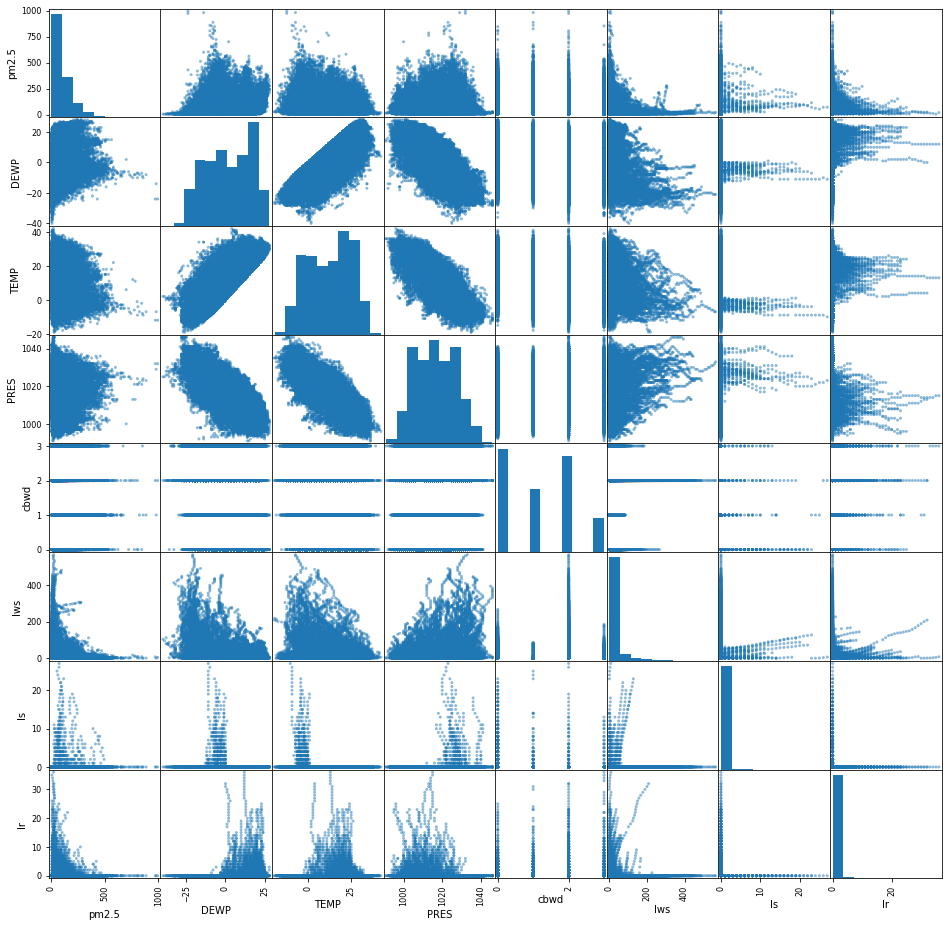

In [94]:
# Multivariate Plots
scatter_matrix(data,figsize=[16,16])
plt.show()

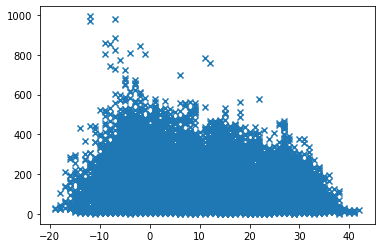

In [102]:
# Zoom in the relation between temp and pm2.5
plt.scatter(data['TEMP'], data['pm2.5'], marker= "x")

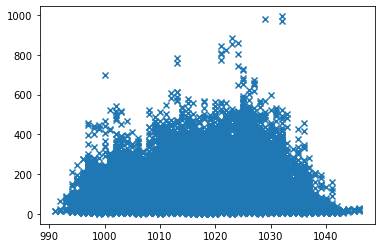

In [124]:
# Zoom in the relation between PRES and pm2.5
plt.scatter(data['PRES'], data['pm2.5'], marker= "x")

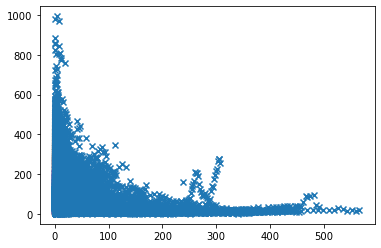

In [126]:
# Zoom in the relation between Iws and pm2.5
plt.scatter(data['Iws'], data['pm2.5'], marker= "x")

### Data Wrangling

In [106]:
data = data.assign(anom=pd.Series(np.zeros(len(data), dtype=np.int)).values)
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom
timestamp,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0,1.79,0,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0,2.68,0,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,0,3.57,0,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,0,5.36,1,0,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,0,6.25,2,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,2,231.97,0,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,2,237.78,0,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,2,242.70,0,0,0


In [107]:
df25 = data.iloc[:, 0]
df25

timestamp
2010-01-02 00:00:00    129.0
2010-01-02 01:00:00    148.0
2010-01-02 02:00:00    159.0
2010-01-02 03:00:00    181.0
2010-01-02 04:00:00    138.0
                       ...  
2014-12-31 19:00:00      8.0
2014-12-31 20:00:00     10.0
2014-12-31 21:00:00     10.0
2014-12-31 22:00:00      8.0
2014-12-31 23:00:00     12.0
Name: pm2.5, Length: 41757, dtype: float64

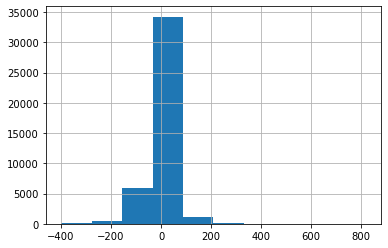

In [208]:
#df25_column = np.pow(df25 - df25.rolling(5).mean())/df25.rolling(5).mean()
# Different rolling map for labeling
# 12hrs
df25_12_column = df25 - df25.rolling(12).mean()
df25_12_column.hist();

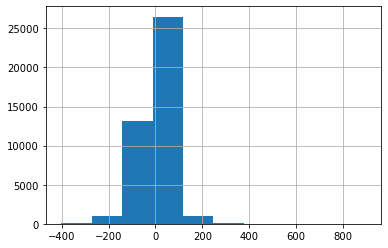

In [209]:
df25_24_column = df25 - df25.rolling(24).mean()
df25_24_column.hist();

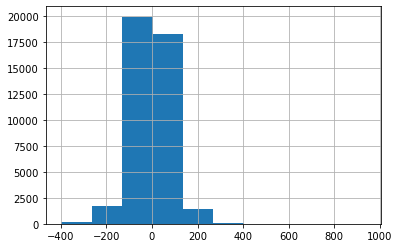

In [211]:
df25_48_column = df25 - df25.rolling(48).mean()
df25_48_column.hist();

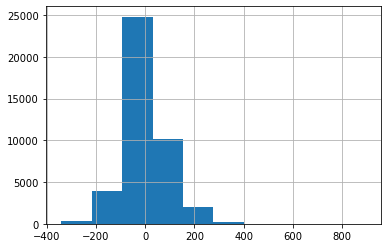

In [212]:
df25_144_column = df25 - df25.rolling(144).mean()
df25_144_column.hist();

In [213]:
df25_24_column

timestamp
2010-01-02 00:00:00         NaN
2010-01-02 01:00:00         NaN
2010-01-02 02:00:00         NaN
2010-01-02 03:00:00         NaN
2010-01-02 04:00:00         NaN
                         ...   
2014-12-31 19:00:00   -3.291667
2014-12-31 20:00:00   -0.625000
2014-12-31 21:00:00   -0.208333
2014-12-31 22:00:00   -2.208333
2014-12-31 23:00:00    1.958333
Name: pm2.5, Length: 41757, dtype: float64

In [214]:
newdata = pd.concat([data, df25_24_column], axis=1)
newdata

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,pm2.5
timestamp,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0,1.79,0,0,0,NaN
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0,2.68,0,0,0,NaN
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,0,3.57,0,0,0,NaN
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,0,5.36,1,0,0,NaN
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,0,6.25,2,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,2,231.97,0,0,0,-3.291667
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,2,237.78,0,0,0,-0.625000
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,2,242.70,0,0,0,-0.208333


In [215]:
newdata.columns.values[-1] = '24_diff_pm_2.5'
newdata

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,24_diff_pm_2.5
timestamp,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0,1.79,0,0,0,NaN
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0,2.68,0,0,0,NaN
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,0,3.57,0,0,0,NaN
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,0,5.36,1,0,0,NaN
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,0,6.25,2,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,2,231.97,0,0,0,-3.291667
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,2,237.78,0,0,0,-0.625000
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,2,242.70,0,0,0,-0.208333


E:\Software\Anaconda3\envs\comp432-project\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
E:\Software\Anaconda3\envs\comp432-project\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
E:\Software\Anaconda3\envs\comp432-project\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


[]

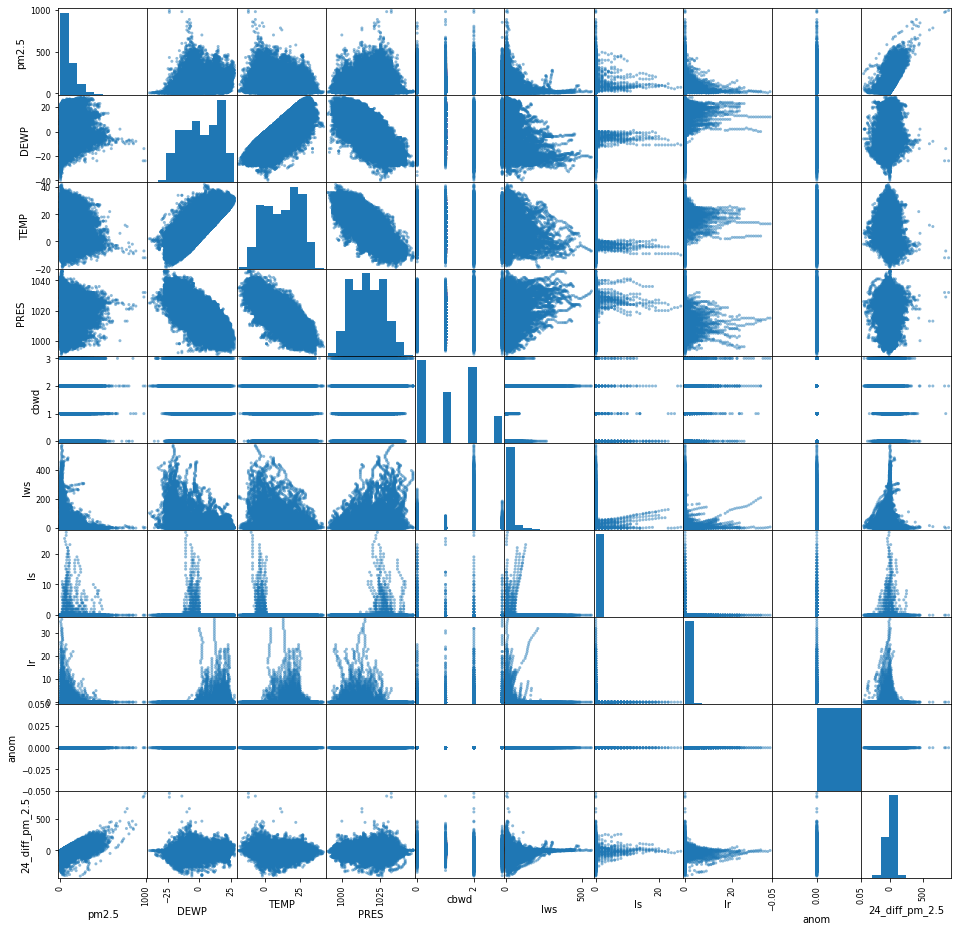

In [216]:
scatter_matrix(newdata,figsize=[16,16])
plt.plot()

In [218]:
newdata['24_diff_pm_2.5'].std()

62.62667219798754

In [225]:
newdata.loc[newdata['24_diff_pm_2.5'] >= 3*(newdata['24_diff_pm_2.5']).std(),'anom'] = 1

In [226]:
newdata[newdata['anom'] == 1]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,24_diff_pm_2.5
timestamp,,,,,,,,,,
2010-01-08 02:00:00,275.0,-20,-16.0,1031.0,3,0.89,0,0,1,190.166667
2010-01-14 01:00:00,257.0,-20,-15.0,1025.0,3,2.67,0,0,1,204.250000
2010-01-16 03:00:00,271.0,-16,-13.0,1035.0,3,0.89,0,0,1,194.541667
2010-01-26 20:00:00,274.0,-11,-5.0,1020.0,3,0.89,0,0,1,200.583333
2010-01-26 21:00:00,340.0,-13,-6.0,1020.0,2,1.79,0,0,1,253.375000
...,...,...,...,...,...,...,...,...,...,...
2014-12-09 15:00:00,390.0,-8,0.0,1031.0,1,0.89,0,0,1,283.541667
2014-12-09 16:00:00,375.0,-8,0.0,1031.0,1,1.78,0,0,1,253.625000
2014-12-09 17:00:00,367.0,-8,0.0,1031.0,3,0.89,0,0,1,231.083333


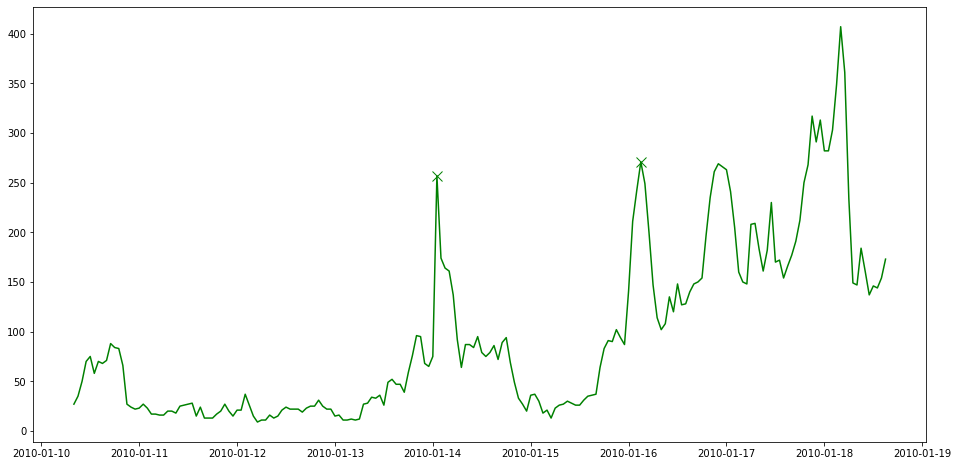

In [224]:
#Flag different color
plt.figure(figsize=(16,8))
#plt.plot(newdata.index[300:1000], newdata['pm2.5'][300:1000], color='green',markersize=6)
plt.plot(newdata['pm2.5'][200:400], markevery=newdata['anom'][200:400]==1, marker='x', color='green',markersize=10)

In [198]:
newdata['20100122':'20100128']

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom,10_diff_pm_2.5
timestamp,,,,,,,,,,
2010-01-22 00:00:00,35.0,-18,-6.0,1036.0,2,7.60,0,0,0,-4.5
2010-01-22 01:00:00,29.0,-20,-4.0,1037.0,2,17.43,0,0,0,-11.7
2010-01-22 02:00:00,26.0,-21,-5.0,1037.0,2,27.26,0,0,0,-15.8
2010-01-22 03:00:00,18.0,-21,-6.0,1037.0,2,35.31,0,0,0,-23.5
2010-01-22 04:00:00,15.0,-20,-7.0,1036.0,2,42.46,0,0,0,-24.0
...,...,...,...,...,...,...,...,...,...,...
2010-01-28 19:00:00,23.0,-20,-1.0,1027.0,2,103.25,0,0,0,6.1
2010-01-28 20:00:00,16.0,-21,-1.0,1027.0,2,105.04,0,0,0,-0.9
2010-01-28 21:00:00,25.0,-21,-4.0,1028.0,3,0.89,0,0,0,7.4


In [227]:
#print(newdata['20100122':'20100128'].to_string())

In [68]:
data.loc[df25_column > 3, 'anom'] = 1
data

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom
timestamp,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,0,1.79,0,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,0,2.68,0,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,0,3.57,0,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,0,5.36,1,0,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,0,6.25,2,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,2,231.97,0,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,2,237.78,0,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,2,242.70,0,0,0


Text(0.5, 1.0, 'PM2.5 with timestamp')

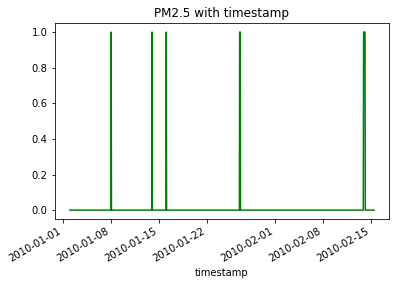

In [229]:
newdata.iloc[1:1000, :]['anom'].plot(kind='line',color='green')
plt.title("PM2.5 with timestamp")

In [ ]:
# Data Splitting
X_trn, X_tst, y_trn, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
print(len(X_trn))
X_trn, X_val, y_trn, y_val = sklearn.model_selection.train_test_split(X_trn, y_trn, test_size=0.2, random_state=1)
X_trn, X_val, X_tst, y_trn, y_val, y_tst
print(len(X_trn), len(y_trn))

In [53]:
newdata = normalized_data
newdata

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
timestamp,,,,,,,,
2010-01-02 00:00:00,0.330110,-1.229777,-1.347127,0.345325,-1.152708,-0.444939,-0.071056,-0.137407
2010-01-02 01:00:00,0.536519,-1.160494,-1.347127,0.345325,-1.152708,-0.427002,-0.071056,-0.137407
2010-01-02 02:00:00,0.656019,-0.883364,-1.429261,0.442406,-1.152708,-0.409064,-0.071056,-0.137407
2010-01-02 03:00:00,0.895018,-0.606234,-1.429261,0.539486,-1.152708,-0.372988,1.212847,-0.137407
2010-01-02 04:00:00,0.427883,-0.606234,-1.429261,0.539486,-1.152708,-0.355051,2.496751,-0.137407
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,-0.984387,-1.714754,-1.182859,1.704452,0.765731,4.194151,-0.071056,-0.137407
2014-12-31 20:00:00,-0.962660,-1.645472,-1.264993,1.704452,0.765731,4.311247,-0.071056,-0.137407
2014-12-31 21:00:00,-0.962660,-1.645472,-1.264993,1.704452,0.765731,4.410405,-0.071056,-0.137407


In [50]:
# Nomalization for only training set or testing set
normalized_data=(data-data.mean())/data.std()

Text(0.5, 1.0, 'PM2.5 with timestamp')

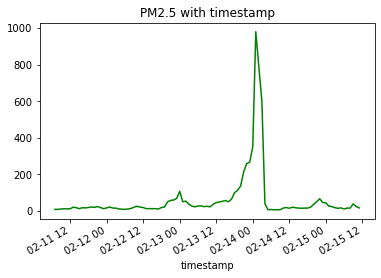

In [230]:
newdata.iloc[900:1000, :]['pm2.5'].plot(kind='line',color='green')
plt.title("PM2.5 with timestamp")

In [62]:
newdata.iloc[950:980, :]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,anom
timestamp,,,,,,,,,
2010-02-13 09:00:00,-0.788842,-1.299059,-1.593529,1.413211,-0.193489,-0.463078,-0.071056,-0.137407,0
2010-02-13 10:00:00,-0.821433,-1.368342,-1.429261,1.413211,-0.193489,-0.445140,-0.071056,-0.137407,0
2010-02-13 11:00:00,-0.669342,-1.368342,-1.264993,1.316130,-1.152708,-0.444939,-0.071056,-0.137407,0
2010-02-13 12:00:00,-0.571570,-1.437624,-1.018591,1.219050,-0.193489,-0.463078,-0.071056,-0.137407,0
2010-02-13 13:00:00,-0.538979,-1.506907,-0.936457,1.121969,-1.152708,-0.444939,-0.071056,-0.137407,0
2010-02-13 14:00:00,-0.495524,-1.506907,-0.772189,1.024889,-0.193489,-0.444939,-0.071056,-0.137407,0
2010-02-13 15:00:00,-0.452070,-1.506907,-0.772189,0.927808,-1.152708,-0.417932,-0.071056,-0.137407,0
2010-02-13 16:00:00,-0.517252,-1.506907,-0.772189,0.927808,-1.152708,-0.336912,-0.071056,-0.137407,0
2010-02-13 17:00:00,-0.376025,-1.506907,-0.854323,0.927808,-1.152708,-0.255893,-0.071056,-0.137407,0


In [ ]:
normal_mask = newdata['anom']==0
anomaly_mask = newdata['anom']==1
newdata.drop('anom',axis=1,inplace=True)
df_normal = newdata[normal_mask]
df_anomaly = newdata[anomaly_mask]

In [ ]:
df_normal.iloc[950:980, :]

In [ ]:
X_normal = df_normal.values
X_anomaly = df_anomaly.values

In [ ]:
X_normal

In [ ]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(
    X_normal, test_size=0.25, random_state=0)

In [ ]:
model = Sequential()
model.add(Dense(5, input_dim=X_normal.shape[1], activation='relu'))
model.add(Dense(4, activation='relu')) # size to compress to
model.add(Dense(5, activation='relu'))
model.add(Dense(X_normal.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_normal_train,x_normal_train,verbose=1,epochs=100)

In [ ]:
# input_dim=X_normal.shape[1]
# hiden_dim = 5
# # first_hidden_layer_dim = 7
# # last_hidden_layer_dim = 7
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(7, activation='elu', input_dim=X_normal.shape[1]), 
# #     tf.keras.layers.GaussianNoise(0.05),
#     tf.keras.layers.Dense(hiden_dim, activation='elu'),
#     tf.keras.layers.Dense(7, activation='elu')
# ])
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(x_normal_train,x_normal_train,verbose=1,epochs=40)

In [ ]:
pred1 = model.predict(x_normal_test)
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_normal_test))
pred2 = model.predict(X_normal)
score2 = np.sqrt(metrics.mean_squared_error(pred2,X_normal))
pred3 = model.predict(X_anomaly)
score3 = np.sqrt(metrics.mean_squared_error(pred3,X_anomaly))
print(f"Out of Sample Normal Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")
print(f"Anomaly Underway Score (RMSE): {score3}")

In [ ]:
X_anomaly.shape

In [ ]:
x = range(221)
y1 = X_anomaly[:, 0]
y2 = pred3[:, 0]
plt.figure
plt.plot(x, y1, '-og');
plt.plot(x, y2, '-or')

In [ ]:
x = range(10000)
y1 = X_normal[:10000, 0]
y2 = pred2[:10000, 0]
plt.figure
plt.plot(x, y1, '-g');
plt.plot(x, y2, '-r');

In [ ]:
X_normal[0]

In [ ]:
pred2[0]